# CS 109B Advanced Topics in Data Science, Final Project, Milestone 4

## Group 9 - Steve Robbins, Chad Tsang, and Ted Heuer
**Harvard University**<br>
**Spring 2017**<br>
**Due Date: ** Wednesday, April 12th, 2017 at 11:59pm

### Milestone 4: Deep learning, due Wednesday, April 26, 2017

For this milestone you will (finally) use deep learning to predict movie genres. You will train one small network from scratch on the posters only, and compare this one to a pre-trained network that you fine tune. [Here](https://keras.io/getting-started/faq/#how-can-i-use-pre-trained-models-in-keras) is a description of how to use pretrained models in Keras.

You can try different architectures, initializations, parameter settings, optimization methods, etc. Be adventurous and explore deep learning! It can be fun to combine the features learned by the deep learning model with a SVM, or incorporate meta data into your deep learning model. 

**Note:** Be mindful of the longer training times for deep models. Not only for training time, but also for the parameter tuning efforts. You need time to develop a feel for the different parameters and which settings work, which normalization you want to use, which model architecture you choose, etc. 

It is great that we have GPUs via AWS to speed up the actual computation time, but you need to be mindful of your AWS credits. The GPU instances are not cheap and can accumulate costs rather quickly. Think about your model first and do some quick dry runs with a larger learning rate or large batch size on your local machine. 

The notebook to submit this week should at least include:

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc. 
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc. 
- Discussion of the results, how much improvement you gained with fine tuning, etc. 
- Discussion of at least one additional exploratory idea you pursued

### Useful links - Delete or cite these.
https://keras.io/callbacks/

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://keras.io/getting-started/faq/#how-can-i-use-keras-with-datasets-that-dont-fit-in-memory

https://elitedatascience.com/keras-tutorial-deep-learning-in-python#step-4

http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/

In [1]:
#!pip install keras 
#!pip install tensorflow
#!pip install tensorflow.python

In [2]:
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np
import pandas as pd
from scipy import misc

In [23]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
from keras import backend as K

### Settings

### Load, split, and prepare the data.

In [4]:
def load_poster_data(image_size, source_size = 'w92', verbose = False):
    # Loads the poster image data at the requested size, the assigned genre, and the movie id.
    #
    y_labels = pd.read_csv('y_labels_multiclass.csv')
    image_path = './posters/' + source_size + '/'
    posters = pd.DataFrame()
    for movie in y_labels.iterrows():
        row = movie[0]
        movie_id = movie[1]['movie_id']
        genre_id = int(movie[1]['genre_id'].replace('[', '').replace(']',''))
        try:
            image = misc.imread(image_path + str(movie_id) + '.jpg')
            image_resize = img_to_array(misc.imresize(image, image_size))
            if (image_resize.shape[2]==3):
                posters = posters.append({'movie_id' : movie_id, 
                                          'genre_id' : genre_id,
                                          'poster' : image_resize}, ignore_index = True)
        except IOError:
            if (verbose == True):
                print('Unable to load poster for movie #', movie_id)
    print('Loaded ', posters.shape[0], ' posters.')
    return posters

In [5]:
def stratified_sampler(dataset, observations):
    # Performs a stratified sample on the dataset and returns the number of observations 
    # requested.
    #
    # Parameters:
    #    dataset:  The dataframe to sample, observing class relationships.
    #    observations:  The number of total target observations across all classes.
    #
    # Returns:
    #    A pandas dataframe sampled from the dataset maintaining class relationships.
    class_weights = dataset.groupby("genre_id").agg(['count'])/len(dataset)
    class_sample_counts = class_weights * observations
    class_count = class_weights.shape[0]
    sampled = pd.DataFrame()
    for class_to_sample in class_sample_counts.iterrows():
        class_name = class_to_sample[0]
        desired_class_observations = class_to_sample[1][0]
        sampled_obs = dataset[dataset["genre_id"]==class_name].sample(int(desired_class_observations), replace="True")
        sampled = sampled.append(sampled_obs, ignore_index=True)
    return sampled, class_count

In [6]:
def reshape_and_normalize(data):
    image_count = data.shape[0]
    temp = np.ndarray(shape=(image_count, data[0].shape[0], data[0].shape[1], 3))

    for index in range(0, image_count):
        try:
            temp[index] = data[index].reshape(data[0].shape[0], data[0].shape[1], 3)
        except ValueError:
            print(data[index].shape)
    temp = temp.astype('float32')
    temp /= 255.0

    return temp

In [7]:
def normalize_responses(data):
    unique_responses = np.sort(data["genre_id"].unique())
    data["genre_id"] = data["genre_id"].replace(unique_responses, range(0,len(unique_responses)), inplace=False)
    return data

In [8]:
def load_split_prepare_data(train_observations, test_observations, image_size, sample = 'stratified'):
    # Loads, splits, and prepares the data for use by a CNN model.
    #
    # Parameters:
    #    train_observations:  The dataframe to sample, observing class relationships.
    #    test_observations:  The number of total target observations across all classes.
    #    sample:  The sampling method, currently only supports 'stratified'
    #
    # Returns:
    #    Nothing.
    posters_data = load_poster_data(image_size)
    posters = normalize_responses(posters_data)
    
    if (sample == 'stratified'):
        train_sample, class_count_train = stratified_sampler(posters, train_observations)
        test_sample, class_count_test = stratified_sampler(posters, test_observations)
    else:
        raise('Unsupported sample method : ', sample)
         
    x_train = train_sample["poster"]
    y_train = train_sample["genre_id"]
    x_test = test_sample["poster"]
    y_test = test_sample["genre_id"]

    img_rows = x_train[0].shape[0]
    img_cols = x_train[0].shape[1]
    print('Classes : ', class_count_train)
        
    x_train = reshape_and_normalize(x_train)
    x_test = reshape_and_normalize(x_test)

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    # Convert response to one hot encoding
    y_train = keras.utils.to_categorical(y_train, class_count_train)
    y_test = keras.utils.to_categorical(y_test, class_count_test)

    return (x_train, y_train), (x_test, y_test), class_count_train

In [9]:
(x_train, y_train), (x_test, y_test), classes = load_split_prepare_data(train_observations = 5000, 
                                                                        test_observations = 1000, 
                                                                        image_size = (138,92), 
                                                                        sample='stratified')

Loaded  6824  posters.
Classes :  7
x_train shape: (4996, 138, 92, 3)
4996 train samples
997 test samples


### Create the Convolutional Neural Net architecture, from scratch.

In [36]:
classes = 7
final_activation_function = 'softmax'

input_activation_function = 'relu'
input_kernel_size = (5,5)
input_shape = (138, 92, 3)
pool_size = (3,3)

hidden_activation_function = 'relu'
hidden_kernel_size = (3,3)

loss_method = 'categorical_crossentropy'
optimizer = SGD(lr=0.1, momentum=0.9)
eval_metric = 'accuracy'

# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 256
# number of iterations over the complete training data
epochs = 100

In [39]:
# create an empty network model
model = Sequential()

# Input Layer
model.add(Conv2D(16, kernel_size=input_kernel_size, activation=input_activation_function, input_shape=input_shape))
model.add(MaxPooling2D(pool_size=pool_size))

# Hidden Layer(s)
model.add(Conv2D(32, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=pool_size))

# Adding another layer did not improve performance, perhaps because of the pooling on pooling.
#model.add(Conv2D(48, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
#model.add(Dropout(0.25))
#model.add(MaxPooling2D(pool_size=pool_size))

# Classification layer
model.add(Flatten())
model.add(Dense(64, activation=hidden_activation_function))
model.add(Dropout(0.5))
model.add(Dense(classes, activation=final_activation_function))

# Display the CNN.
model.summary()

# Compile the model.
model.compile(loss=loss_method, optimizer=optimizer, metrics=[eval_metric])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 134, 88, 16)       1216      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 44, 29, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 42, 27, 32)        4640      
_________________________________________________________________
dropout_17 (Dropout)         (None, 42, 27, 32)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 14, 9, 32)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                258112    
__________

### Train the CNN.

In [40]:
# The actual training of the CNN using the parameters and model previously specified.
# The validation set is a split of the stratified sampled training data.
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split = 0.15)

# Evaluate the performance on the unused testing set.
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 4246 samples, validate on 750 samples
Epoch 1/40
4246/4246 [==============================] - 47s - loss: 1.6231 - acc: 0.2756 - val_loss: 4.0526 - val_acc: 0.0000e+00
Epoch 2/40
4246/4246 [==============================] - 46s - loss: 1.7014 - acc: 0.2765 - val_loss: 3.0914 - val_acc: 0.0000e+00
Epoch 3/40
4246/4246 [==============================] - 45s - loss: 1.5846 - acc: 0.2892 - val_loss: 4.4150 - val_acc: 0.0000e+00
Epoch 4/40
4246/4246 [==============================] - 45s - loss: 1.5365 - acc: 0.3121 - val_loss: 5.2125 - val_acc: 0.0000e+00
Epoch 5/40
4246/4246 [==============================] - 44s - loss: 1.4745 - acc: 0.3860 - val_loss: 5.5264 - val_acc: 0.0000e+00
Epoch 6/40
4246/4246 [==============================] - 45s - loss: 1.4472 - acc: 0.4013 - val_loss: 5.5061 - val_acc: 0.0000e+00
Epoch 7/40
4246/4246 [==============================] - 44s - loss: 1.4315 - acc: 0.4105 - val_loss: 5.6866 - val_acc: 0.0000e+00
Epoch 8/40
4246/4246 [=====================

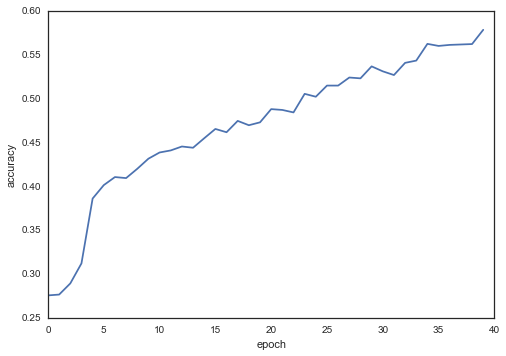

In [41]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")


### Tune an existing CNN.

In [ ]:
TODO - Break the compilation of the notebook on purpose as the following is just a sample.

In [ ]:
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3

model = VGG16(weights='imagenet', include_top=True)

In [ ]:
'''This script goes along the blog post
"Building powerful image classification models using very little data"
from blog.keras.io.
It uses data that can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1400 in data/validation/cats
- put the dogs pictures index 12500-13499 in data/train/dogs
- put the dog pictures index 13500-13900 in data/validation/dogs
So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```
'''

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

# path to the model weights files.
weights_path = '../keras/examples/vgg16_weights.h5'
top_model_weights_path = 'fc_model.h5'
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'cats_and_dogs_small/train'
validation_data_dir = 'cats_and_dogs_small/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

# build the VGG16 network
model = applications.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model.add(top_model)

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

# fine-tune the model
model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)